In [1]:
# CPU SIM

In [1]:
# # Import required packages
# import gymnasium as gym
# import mani_skill.envs
# import time
# env = gym.make("PushCube-v1")
# obs, _ = env.reset(seed=0)
# env.unwrapped.print_sim_details() # print verbose details about the configuration
# done = False
# start_time = time.time()
# while not done:
#     obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
#     done = terminated or truncated
# N = info["elapsed_steps"].item()
# dt = time.time() - start_time
# FPS = N / (dt)
# print(f"Frames Per Second = {N} / {dt} = {FPS}")

In [2]:
# import matplotlib.pyplot as plt
# env = gym.make("PushCube-v1", render_mode="rgb_array")
# env.reset()
# obs = env.render()[0].numpy()
# plt.imshow(obs) # we take [0].numpy() as everything is a batched tensor
# plt.show()

In [3]:
# GPU SIM (state-only)

In [4]:
### Make sure to restart the notebook if you already ran a CPU sim!! ###
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 2048 # you can go up to 4096 on better GPUs
env = gym.make("PickCube-v1", num_envs=num_envs)
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

# -------------------------------------------------------------------------- #
Task ID: PickCube-v1, 2048 parallel environments, sim_backend=gpu
obs_mode=state, control_mode=pd_joint_delta_pos
render_mode=None, sensor_details=RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Box(-inf, inf, (2048, 42), float32)
(single) action space: Box(-1.0, 1.0, (8,), float32)
# -------------------------------------------------------------------------- #
Frames Per Second = 102400 / 2.897425651550293 = 35341.717895404836


In [5]:
# GPU SIM (state+visual)

In [6]:
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 512 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("PickCube-v1", num_envs=num_envs, obs_mode="rgbd")
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

# -------------------------------------------------------------------------- #
Task ID: PickCube-v1, 512 parallel environments, sim_backend=gpu
obs_mode=rgbd, control_mode=pd_joint_delta_pos
render_mode=None, sensor_details=RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Dict('agent': Dict('qpos': Box(-inf, inf, (512, 9), float32), 'qvel': Box(-inf, inf, (512, 9), float32)), 'extra': Dict('is_grasped': Box(False, True, (512,), bool), 'tcp_pose': Box(-inf, inf, (512, 7), float32), 'goal_pos': Box(-inf, inf, (512, 3), float32)), 'sensor_param': Dict('base_camera': Dict('extrinsic_cv': Box(-inf, inf, (512, 3, 4), float32), 'cam2world_gl': Box(-inf, inf, (512, 4, 4), float32), 'intrinsic_cv': Box(-inf, inf, (512, 3, 3), float32))), 'sensor_data': Dict('base_camera': Dict('rgb': Box(0, 255, (512, 128, 128, 3), uint8), 'depth': Box(-32768, 32767, (512, 128, 128, 1), int16))))
(single) action space: Box(-1.0, 1.0, (8,), float32)
# -----------------------------------------------

dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data'])
dict_keys(['base_camera'])
dict_keys(['rgb', 'depth', 'segmentation'])
torch.Size([4, 128, 128, 3])


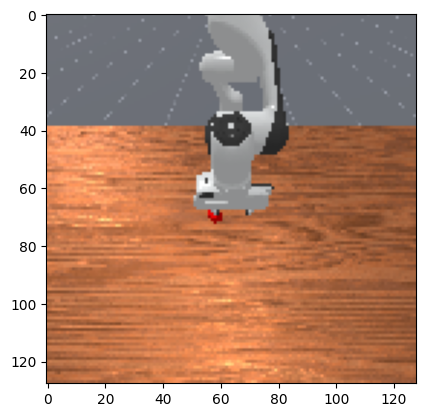

In [18]:
# visualize the image data from the environment and inspect the data
print(obs.keys())
print(obs['sensor_data'].keys())
print(obs['sensor_data']['base_camera'].keys())
print(obs['sensor_data']['base_camera']['rgb'].shape)
import matplotlib.pyplot as plt
plt.imshow(obs['sensor_data']['base_camera']['rgb'][0].cpu().numpy())
plt.show()

## 1.4 Changing the Environment's Observations and Controllers

In [11]:
# Import required packages
import gymnasium as gym
from tqdm.notebook import tqdm
import numpy as np
import mani_skill.envs
import matplotlib.pyplot as plt

Action Space: Box(-1.0, 1.0, (4, 8), float32)


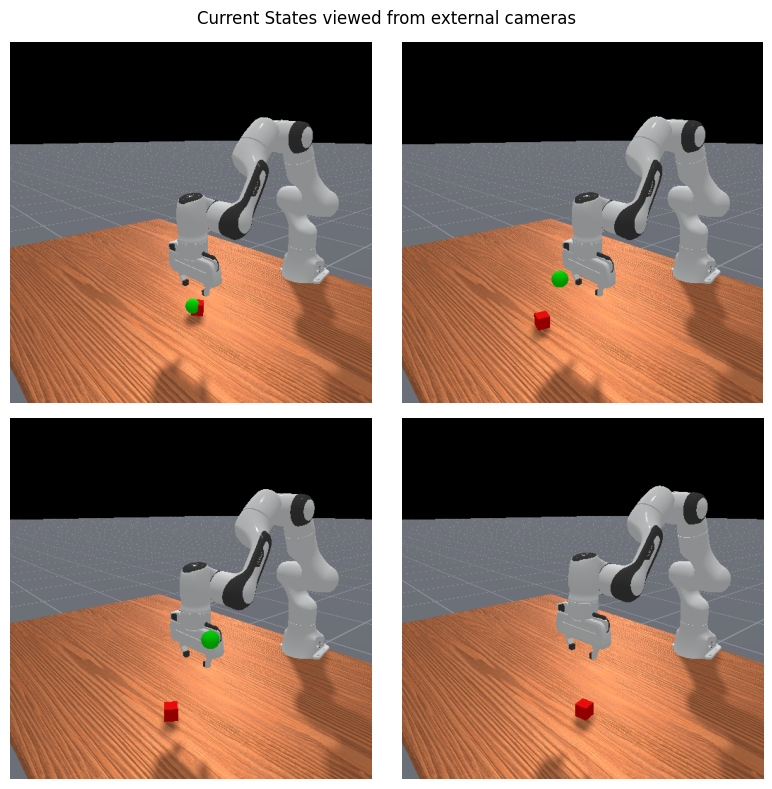

In [25]:
#@markdown Run this cell to display the action space of the chosen controller as well as the current view of the environment
# Can be any env_id from the list of Rigid-Body envs: https://maniskill.readthedocs.io/en/latest/tasks/index.html
env_id = "PickCube-v1" #@param ['PickCube-v1', 'PegInsertionSide-v1', 'StackCube-v1']

# choose an observation type and space, see https://maniskill.readthedocs.io/en/latest/user_guide/concepts/observation.html for details
obs_mode = "rgb+depth+segmentation" #@param can be one of ['pointcloud', 'rgb+depth+segmentation', 'state_dict', 'state']

# choose a controller type / action space, see https://maniskill.readthedocs.io/en/latest/user_guide/concepts/controllers.html for a full list
control_mode = "pd_joint_delta_pos" #@param can be one of ['pd_ee_delta_pose', 'pd_ee_delta_pos', 'pd_joint_delta_pos', 'arm_pd_joint_pos_vel']

reward_mode = "dense" #@param can be one of ['sparse', 'dense']

robot_uids = "panda" #@param can be one of ['panda', 'fetch']

# create an environment with our configs and then reset to a clean state
env = gym.make(env_id,
               num_envs=4,
               obs_mode=obs_mode,
               reward_mode=reward_mode,
               control_mode=control_mode,
               robot_uids=robot_uids,
               enable_shadow=True # this makes the default lighting cast shadows
               )
obs, _ = env.reset()
print("Action Space:", env.action_space)

# take a look at the current state of the 4 parallel environments we created
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
rgbs = env.render_rgb_array() # this is a easy way to get the rgb array without having to set render_mode
for i, ax in enumerate(axs.flatten()):
    ax.imshow(rgbs[i].cpu().numpy())
    ax.axis("off")
plt.suptitle("Current States viewed from external cameras")
fig.tight_layout()
env.close()

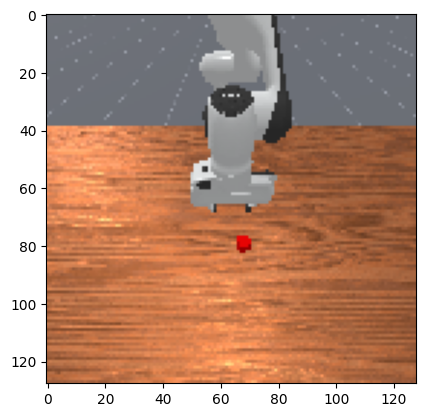

In [39]:
# real observation
plt.imshow(obs['sensor_data']['base_camera']['rgb'][3].cpu().numpy())
plt.show()

In [35]:
# some visualization functions for different observation modes
def show_camera_view(obs_camera, title, env_id=0):
    plt.figure()
    rgb, depth = obs_camera['rgb'], obs_camera['depth']
    plt.subplot(1,3,1)
    plt.title(f"{title} - RGB")
    plt.imshow(rgb[env_id].cpu().numpy())
    plt.subplot(1,3,2)
    plt.title(f"{title} - Depth")
    plt.imshow(depth[..., 0][env_id].cpu().numpy(), cmap="gray")
    plt.subplot(1,3,3)
    plt.title(f"{title} - Segmentation")
    plt.imshow(obs_camera["segmentation"][..., 0][env_id].cpu().numpy())

def show_pointcloud(obs, env_id=0):
    import trimesh
    v = obs['pointcloud']['xyzw'][env_id, ..., :3].cpu().numpy()
    cam2world = obs["sensor_param"]["base_camera"]["cam2world_gl"][env_id].cpu().numpy()
    cam2world = cam2world
    camera = trimesh.scene.Camera("camera", (1024, 1024), fov=(np.rad2deg(np.pi/2), np.rad2deg(np.pi/2)))
    s = trimesh.Scene([trimesh.points.PointCloud(v, obs['pointcloud']['rgb'][env_id].cpu().numpy())], camera=camera, camera_transform=cam2world)
    return s.show()

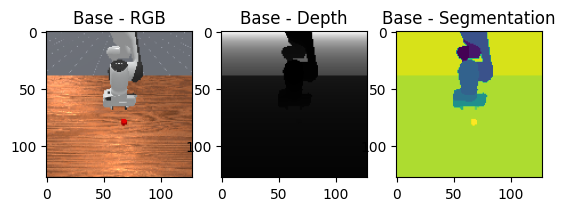

In [38]:
#@markdown Display the RGBD+Segmentation observation. Make sure you are using `obs_mode="rgbd"`
show_camera_view(obs['sensor_data']['base_camera'], "Base", env_id=3)


## 1.5 Interactive Viewer and Recording videos

In [5]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
# to make it look a little more realistic, we will enable shadows which make the default lighting cast shadows
env = gym.make("PickCube-v1", num_envs=4, render_mode="rgb_array", 
               enable_shadow=True, obs_mode="rgb+depth+segmentation", reward_mode="dense")

# render_mode="sensors" for real observations (rgb+d) or "rgb_array" for external camera
env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    # on GPU sim we record intervals, not by single episodes as there are multiple envs
    # each 100 steps a new video is saved
    max_steps_per_video=100
)

# step through the environment with random actions
obs, _ = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

/opt/conda/envs/maniskill/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.max_episode_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_episode_steps` for environment variables or `env.get_wrapper_attr('max_episode_steps')` that will search the reminding wrappers.
  logger.warn(
2024-10-29 21:02:36,790 - mani_skill  - WARNING - mani_skill is not installed with git.


  0%|          | 0/100 [00:00<?, ?it/s]

<KeysViewHDF5 ['traj_0', 'traj_1', 'traj_2', 'traj_3']>
<KeysViewHDF5 ['obs', 'actions', 'terminated', 'truncated', 'success', 'env_states', 'rewards']>
actions (100, 8)
obs (101, 128, 128, 3)
terminated (100,)
truncated (100,)
success (100,)
rewards (100,)


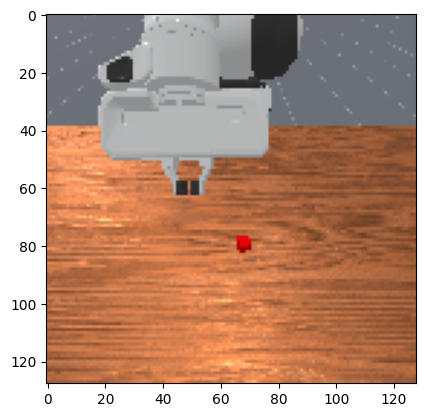

In [8]:
import h5py
import matplotlib.pyplot as plt

with h5py.File("./videos/20241029_210236.h5", "r") as f:
    # Print available trajectories
    print(f.keys())
    traj = f["traj_3"]
    print(traj.keys())
    print("actions", traj["actions"].shape)
    print("obs", traj["obs"]['sensor_data']['base_camera']['rgb'][()].shape)
    print('terminated', traj["terminated"][()].shape)
    print('truncated', traj["truncated"][()].shape)
    print('success', traj["success"][()].shape)
    print('rewards', traj["rewards"][()].shape)
    plt.imshow(traj["obs"]['sensor_data']['base_camera']['rgb'][()][-1]) # -1 -- last frame
    plt.show()


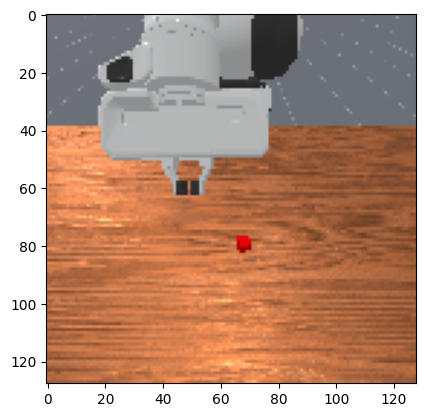

In [7]:
plt.imshow(obs['sensor_data']['base_camera']['rgb'][3].cpu().numpy())
plt.show()